In [1]:
!rm -rf /kaggle/working/*

In [2]:
!git clone https://github.com/facebookresearch/sam2.git

%cd /kaggle/working/sam2

!pip install -e .

!wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 38.79 MiB/s, done.
Resolving deltas: 100% (375/375), done.
/kaggle/working/sam2
Obtaining file:///kaggle/working/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manyli

In [3]:
import cv2
import random
import os
import math
import numpy as np
import pydicom
import torch

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from PIL import Image
from skimage import color

import warnings
warnings.filterwarnings("ignore")

input_dir = '/kaggle/input/brain-tumor-progression-tcia/Brain-Tumor-Progression'
output_dir = '/kaggle/working/'

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
def data_and_mask_to_list(read_dir : str) -> None:
    t1post_images = []
    mask_tumor_image = []
    
    for folder in os.listdir(read_dir):
        if folder.find("T1post") > -1:
            t1post_images_path = [ read_dir + '/' + folder + '/' + image for image in os.listdir(read_dir + '/' + folder) ]
        elif folder.find("MaskTumor") > -1:
            mask_tumor_images_path = [ read_dir + '/' + folder + '/' + image for image in os.listdir(read_dir + '/' + folder) ]

    return list(zip(t1post_images_path, mask_tumor_images_path))

In [5]:
def create_needed_folders(parent_folder_name: str) -> None:
    os.makedirs(parent_folder_name + '/' + 'Train')
    os.makedirs(parent_folder_name + '/' + 'Train/' + 'Mask')
    os.makedirs(parent_folder_name + '/' + 'Train/' + 'Image')
    
    os.makedirs(parent_folder_name + '/' + 'Test')
    os.makedirs(parent_folder_name + '/' + 'Test/' + 'Mask')
    os.makedirs(parent_folder_name + '/' + 'Test/' + 'Image')

In [6]:
patients = [p for p in os.listdir(input_dir)]
patients.remove('LICENSE')

data_mask_path_list = []

for patient in patients:
    os.makedirs(output_dir + patient)
    create_needed_folders(output_dir + patient)
    for dir in os.listdir(input_dir + '/' + patient):
        data_mask_path_list.extend(data_and_mask_to_list(input_dir + "/" + patient + "/" + dir))

random.shuffle(data_mask_path_list)

train_data_path_list = data_mask_path_list[: int(len(data_mask_path_list)  * 0.8)]
test_data_path_list = data_mask_path_list[int(len(data_mask_path_list) * 0.8) :]

trainX, trainY = [x[0] for x in train_data_path_list], [y[1] for y in train_data_path_list]
testX, testY = [x[0] for x in test_data_path_list], [y[1] for y in test_data_path_list]

In [7]:
def DICOM_to_PNG(dataset: str) -> None:
    for case in dataset:
        patient = case[case.find('PGBM-0'): case.find('PGBM-0') + 8]

        folder = None
        if case in trainX or case in trainY:
            folder = 'Train'
        elif case in testX or case in testY:
            folder = 'Test'
        
        if case.find('T1post') != -1:
            folder += '/Image'
        else:
            folder += '/Mask'

        name = case[case.find('.dcm') - 4: case.find('.dcm')]
        img = pydicom.dcmread(case).pixel_array.astype(float)
        scaled_img = np.uint8((np.maximum(img, 0) / img.max()) * 255)
        cv2.imwrite(output_dir + patient + '/' + folder + '/' + name + '.png', scaled_img)

In [8]:
DICOM_to_PNG(trainX)
DICOM_to_PNG(trainY)

DICOM_to_PNG(testX)
DICOM_to_PNG(testY)

In [9]:
train_df = []
test_df = []
skipped_dir = ['.virtual_documents', 'sam2', '']

for patient in os.listdir(output_dir):
    if patient in skipped_dir:
        continue
    
    for image in os.listdir(output_dir + patient + '/Train/Image'):
        train_df.append({
            "image": output_dir + patient + '/Train/Image/' +  image,
            "annotation": output_dir + patient + '/Train/Mask/' +  image
        })

    for image in os.listdir(output_dir + patient + '/Test/Image'):
        test_df.append({
            "image": output_dir + patient + '/Test/Image/' +  image,
            "annotation": output_dir + patient + '/Test/Mask/' +  image
        })

In [10]:
def read_batch(data : list, visualize_data : bool = False) :
    # Select a random entry
    ent = data[np.random.randint(len(data))]
 
    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    ### Continuation of read_batch() ### 

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []
    
    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)
    ### Continuation of read_batch() ###

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(ann_map, cmap='gray')
        plt.axis('off')
        
        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')
        
        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = np.transpose(binary_mask, [2, 0, 1])
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

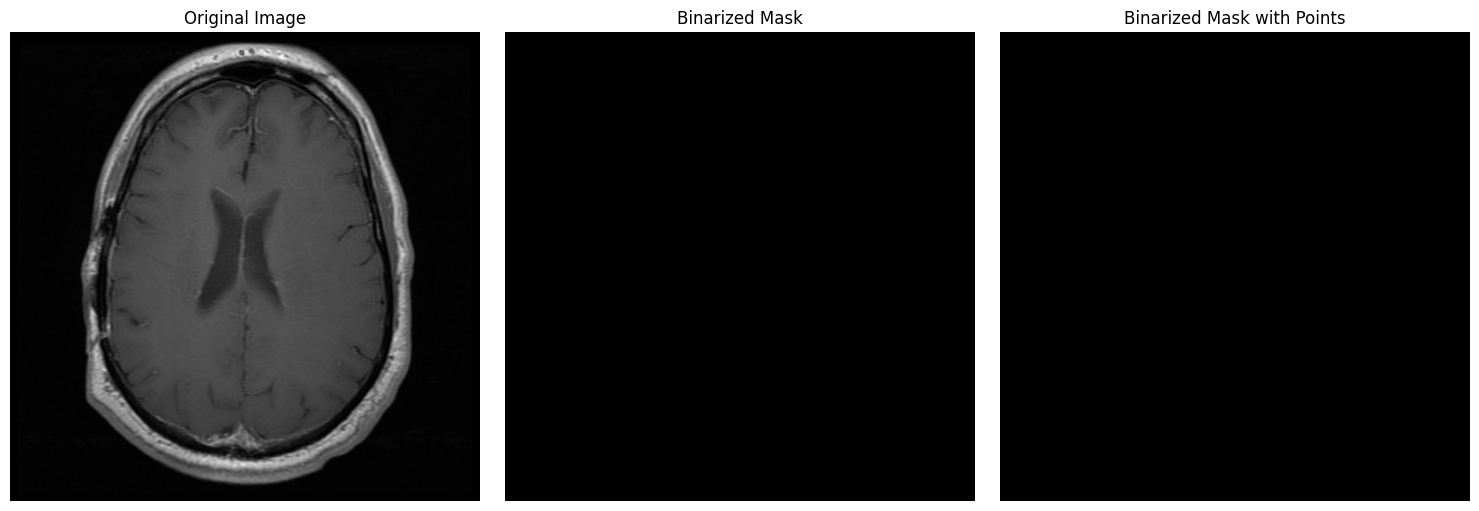

In [11]:
# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_df, visualize_data=True)

In [12]:
sam2_checkpoint = "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml" 

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [13]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 5000

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "medical_sam2"

In [14]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

mean_iou = 0

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(train_df, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 10000 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)

Step 100:	 Accuracy (IoU) =  0.11720386015620848
Step 600:	 Accuracy (IoU) =  0.3747609138640049
Step 1600:	 Accuracy (IoU) =  0.49346297047073784
Step 1800:	 Accuracy (IoU) =  0.44628440084794974
Step 2900:	 Accuracy (IoU) =  0.4938920025930416
Step 3000:	 Accuracy (IoU) =  0.4878810772492395
Step 3300:	 Accuracy (IoU) =  0.4689582539944899
Step 3600:	 Accuracy (IoU) =  0.45094319491951906
Step 3700:	 Accuracy (IoU) =  0.46697880101412614
Step 4400:	 Accuracy (IoU) =  0.4945060805205541
Step 5000:	 Accuracy (IoU) =  0.49151852317263905


In [15]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [16]:
FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_100000.torch"

torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

failed, retrying
failed, retrying
failed, retrying


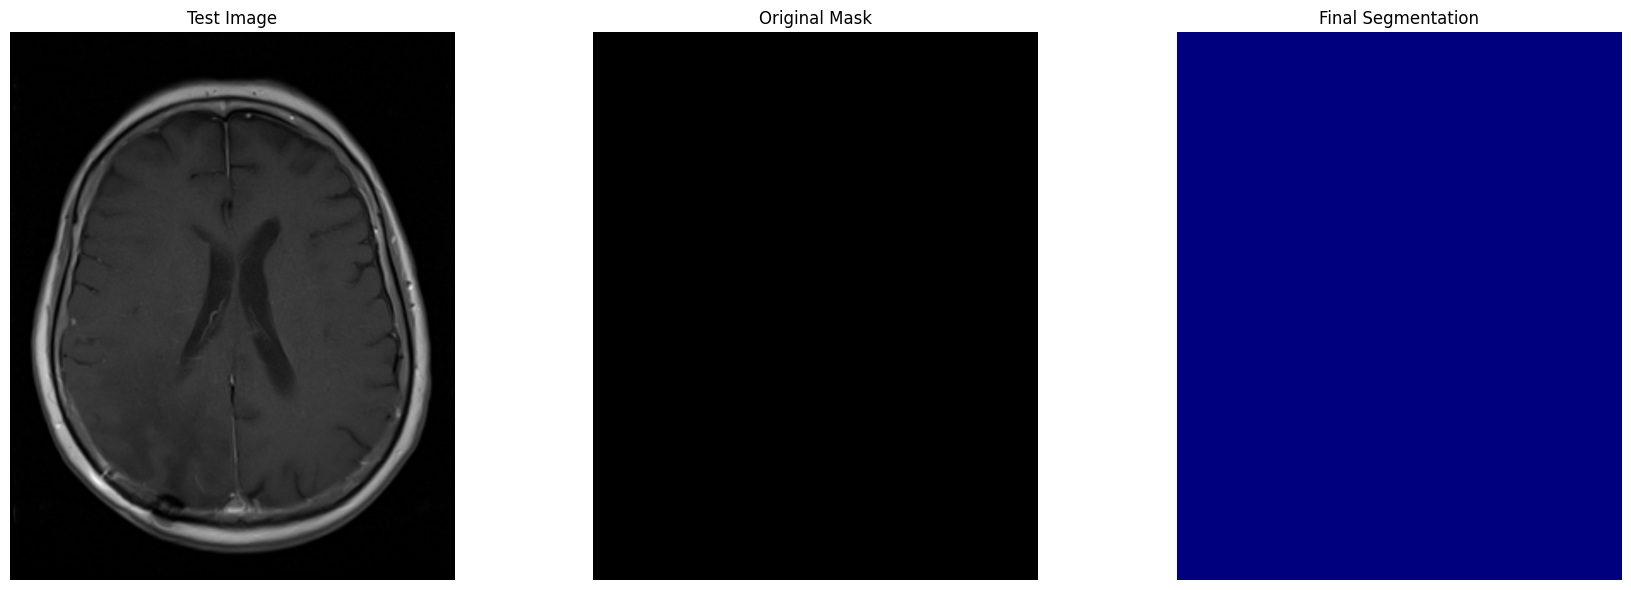

In [17]:
passed = False

while not passed:
   try:
       # Randomly select a test image from the test_data
       selected_entry = random.choice(test_df)
       image_path = selected_entry['image']
       mask_path = selected_entry['annotation']
        
       # Load the selected image and mask
       image, mask = read_image(image_path, mask_path)
        
       # Generate random points for the input
       num_samples = 30  # Number of points per segment to sample
       input_points = get_points(mask, num_samples)
       passed = True
        
   except:
       print('failed, retrying')
       passed = False

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "medical_sam2_100000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()